In [1]:
!pip install ipynb

Files already downloaded and verified
Epoch [50/50] Batch 1562/1563                   Loss Discriminator: -14.703, loss Generator: 8.348, FID Score: 311.537   

 elapsed time：6683.24 s.


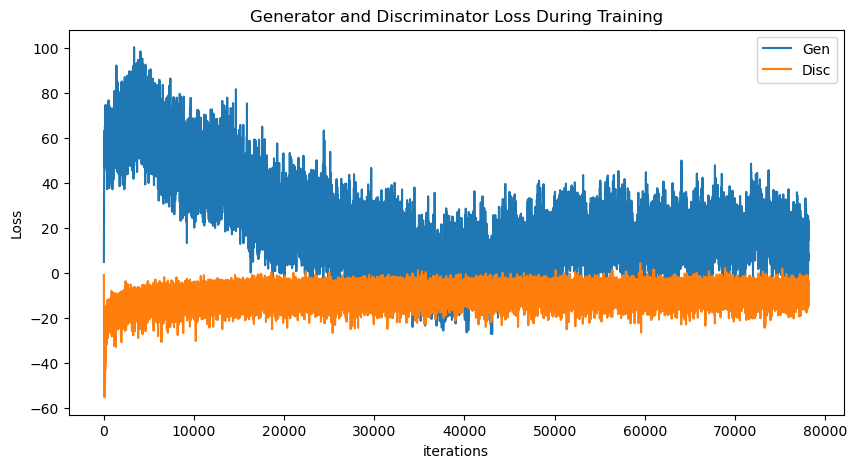

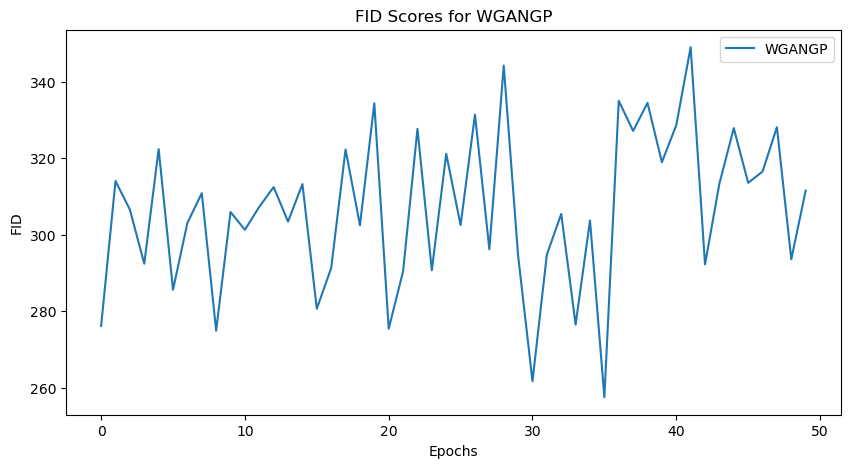

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
import os
from ipynb.fs.full.FID import calculate_fretchet


torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 2e-4
batch_size = 32
image_size = 64
img_channels = 3  
noise_dim = 100
max_epochs = 50
discriminator_features = 64 
generator_features = 64 
criticItr = 5
lambda_GP = 10


dataset = datasets.CIFAR10(root="./dataset/CIFAR10", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5 for _ in range(img_channels)], [0.5 for _ in range(img_channels)]),
                           ]))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)



class Discriminator(nn.Module):
    def __init__(self, img_channels, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(img_channels, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self.block(features_d, features_d * 2, 4, 2, 1),      
            self.block(features_d * 2, features_d * 4, 4, 2, 1), 
            self.block(features_d * 4, features_d * 8, 4, 2, 1), 
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )
        
    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False,),
            nn.InstanceNorm2d(out_channels, affine =True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)
    
    
class Generator(nn.Module):
    def __init__(self, channels_noise, img_channels, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self.block(channels_noise, features_g*8, 4, 1, 0),       
            self.block(features_g*8, features_g*4, 4, 2, 1), 
            self.block(features_g*4, features_g*2, 4, 2, 1),  
            self.block(features_g*2, features_g, 4, 2, 1), 
            nn.ConvTranspose2d(features_g, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh() 
        )

    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False,),
            nn.BatchNorm2d(out_channels,momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)
    

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
            
def GP (critic, real, fake):
    batch_size, C, H, W = real.shape
    alpha = torch.rand((batch_size, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)
    mixed_scores = critic(interpolated_images)
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


generator = Generator(noise_dim, img_channels, generator_features).to(device)
discriminator = Discriminator(img_channels, discriminator_features).to(device)
initialize_weights(generator)
initialize_weights(discriminator)
gen_optimizer = optim.RMSprop(generator.parameters(), lr=learning_rate)
disc_optimizer = optim.RMSprop(discriminator.parameters(), lr=learning_rate)
fixed_noise = torch.randn(batch_size, noise_dim, 1, 1).to(device)
step = 0



#training block
generator.train()
discriminator.train()
GenLoss = []
DiscLoss = []
DiscLossP = []
img_list = []
iters = 0
FID_list = []
best_fid = float('inf')


for epoch in range(max_epochs):
    epoch = epoch+1
    for batch_idx, data in enumerate(dataloader,0):
        real = data[0].to(device)
        batch = real.shape[0]
        for i in range (criticItr):
            noise = torch.randn(batch, noise_dim, 1, 1).to(device)
            fake = generator(noise)
            critic_real = discriminator(real).reshape(-1)
            critic_fake = discriminator(fake).reshape(-1)
            gp = GP(discriminator, real,fake)
            loss_critic = (-(torch.mean(critic_real) - torch.mean(critic_fake))+ (lambda_GP*gp))
            discriminator.zero_grad()
            loss_critic.backward(retain_graph=True)
            disc_optimizer.step()

        # Train Generator
        output = discriminator(fake).reshape(-1)
        loss_gen = -torch.mean(output) 
        generator.zero_grad()
        loss_gen.backward()
        gen_optimizer.step()

        GenLoss.append(loss_gen.detach().cpu())
        DiscLoss.append(loss_critic.detach().cpu())

    
        if (iters % 500 == 0) or ((epoch == max_epochs) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
    fretchet_dist=calculate_fretchet(real,fake)
    FID_list.append(fretchet_dist)
    print(f"Epoch [{epoch}/{max_epochs}] Batch {batch_idx}/{len(dataloader)} \
                  Loss Discriminator: {loss_critic:.3f}, loss Generator: {loss_gen:.3f}, FID Score: {fretchet_dist:.3f} ", end="\r", flush=True) 
        


plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(GenLoss,label="Gen")
plt.plot(DiscLoss,label="Disc")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('WGAN_Loss.pdf', format='pdf', dpi=100, bbox_inches='tight')
plt.show()


plt.figure(figsize=(10,5))
plt.title("FID Scores for WGANGP")
plt.plot(FID_list,label="WGANGP")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()
plt.savefig('Results/WGAN_FID.pdf', format='pdf', bbox_inches='tight')
plt.show()

np.save('WGANGP_FID', FID_list) 